In [64]:
import os
from os.path import expanduser, join
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import contextily as ctx
import ulmo
import rasterio as rio
from rasterio.features import dataset_features
import pickle
import pyproj
from shapely.ops import unary_union
from conversion import imperial_to_metric
from rasterio.windows import Window


In [2]:
#This is the latest CUAHSI API endpoint
wsdlurl = 'https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL'
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

In [3]:
sites_gdf_conus = gpd.read_file('~/scratch/data/uavsar/snotel/ulmo_sites.json')

In [43]:
def raster_box_extract(img, x_coord, y_coord, box_side = 5):
    meta = img.meta

    # Use the transform in the metadata and your coordinates
    rowcol = rio.transform.rowcol(meta['transform'], xs=x_coord, ys=y_coord)

    w = img.read(1, window=Window(rowcol[1], rowcol[0], box_side, box_side))

    return w

In [85]:
#Get current datetime
today = datetime.today().strftime('%Y-%m-%d')

def snotel_fetch(sitecode, variablecode='SNOTEL:SNWD_D', start_date='1950-10-01', end_date=today):
    #print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(wsdlurl, sitecode, variablecode, start=start_date, end=end_date)
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'], utc=True)
        #Set the DataFrame index to the Timestamps
        values_df = values_df.set_index('datetime')
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except Exception as e:
        print(e)
        print("Unable to fetch %s" % variablecode)

    return values_df
def get_snotel_image_results(img_fp, inc_fp, ann_fp, snotel_gdf, variable = 'SNOTEL:SNWD_D', bbox_side = 5):
    ann = pd.read_csv(ann_fp)
    with rio.open(img_fp) as src, rio.open(inc_fp) as inc_src:
        shapes = list(dataset_features(src, bidx=1, as_mask=False, geographic=True, band=False))
        result = gpd.GeoDataFrame.from_dict(shapes, crs = 'EPSG:4326')
        for i in result.index:
            result.iloc[i]['geometry'] = Polygon(result.iloc[i]['geometry']['coordinates'][0])
        boundary = gpd.GeoSeries(unary_union(result['geometry']))
        boundary_gdf = gpd.GeoDataFrame(boundary, columns = ['geometry'], crs = snotel_gdf.crs)
        points_within = gpd.sjoin(snotel_gdf, boundary_gdf, predicate='within')
        res = {}
        for _, r in points_within.iterrows():
            d = {}
            s = pd.to_datetime(ann.loc[0, 'start time of acquisition for pass 1'])
            e = pd.to_datetime(ann.loc[0, 'start time of acquisition for pass 2'])
            values = snotel_fetch(r['code'], variablecode=variable, start_date=s, end_date=e)
            # Get units
            unit = ulmo.cuahsi.wof.get_variable_info(wsdlurl, variable)['units']['name']
            d['sds'] = imperial_to_metric(values['value'], unit)
            d['phase'] = raster_box_extract(src, r.geometry.x, r.geometry.y, bbox_side)
            d['inc'] = raster_box_extract(inc_src, r.geometry.x, r.geometry.y, bbox_side)
            res[r['code']] = d

    return res

In [18]:
with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

In [86]:
fps = image_fps[0]

res = get_snotel_image_results(fps['fp'], fps['inc'], fps['ann'], sites_gdf_conus)

/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/geopandas/geodataframe.py:475: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  return GeoDataFrame(dataframe, geometry=geometry, crs=crs)


In [87]:
res

{'919_MT_SNTL': {'sds': array([0.5588, 0.5588, 0.5588, 0.5334, 0.5334, 0.5588, 0.5334, 0.5334,
       0.5334, 0.5334, 0.5842, 0.6096, 0.5842, 0.5842, 0.6096, 0.5588,
       0.635 , 0.7366, 0.8128, 0.8128, 0.7874, 0.7874, 0.762 , 0.7874,
       0.762 , 0.762 , 0.762 , 0.762 , 0.7874, 0.8382, 0.8128, 0.8128,
       0.8128, 0.8128, 0.8636]), 'phase': array([[3.2666671, 3.2666671,       nan,       nan,       nan],
       [      nan,       nan,       nan,       nan,       nan],
       [      nan,       nan,       nan,       nan,       nan],
       [      nan,       nan,       nan,       nan,       nan],
       [2.6490548, 2.6490548,       nan,       nan,       nan]],
      dtype=float32), 'inc': array([[0.8344763 , 0.838333  , 0.84219044, 0.84604824, 0.8499066 ],
       [0.8378341 , 0.8422024 , 0.8465718 , 0.850942  , 0.8553131 ],
       [0.8424131 , 0.8472928 , 0.85217416, 0.857057  , 0.8619409 ],
       [0.8469929 , 0.8523838 , 0.8577771 , 0.86317277, 0.8685702 ],
       [0.8515733 , 0.85

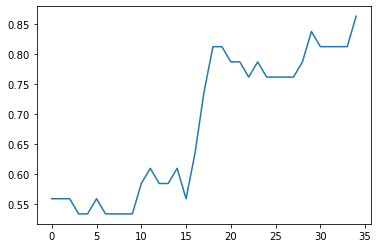

In [79]:
plt.plot(imperial_to_metric(res['919_MT_SNTL']['record']['value'], res['919_MT_SNTL']['unit']))